In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import tensorflow as tf
import numpy as np
from pathlib import Path
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
import matplotlib.pyplot as plt

2024-02-25 05:44:58.507074: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
sp_index = pd.read_csv("sp500_index.csv")
sp_index

,Date,S&P500
0,2014-02-18,1840.76
1,2014-02-19,1828.75
2,2014-02-20,1839.78
3,2014-02-21,1836.25
4,2014-02-24,1847.61
...,...,...
2511,2024-02-08,4997.91
2512,2024-02-09,5026.61
2513,2024-02-12,5021.84
2514,2024-02-13,4953.17


In [4]:
sp_stocks = pd.read_excel("sp500_stocks_4years.xlsx")
sp_stocks.head()


,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2020-01-02,MMM,166.588959,180.000000,180.009995,177.139999,177.679993,3601700.0
1,2020-01-03,MMM,165.154465,178.449997,178.660004,175.630005,177.020004,2466900.0
2,2020-01-06,MMM,165.311783,178.619995,178.710007,176.350006,177.149994,1998000.0
3,2020-01-07,MMM,164.645416,177.899994,178.509995,176.820007,178.279999,2173000.0
4,2020-01-08,MMM,167.172028,180.630005,181.500000,177.649994,178.000000,2758300.0


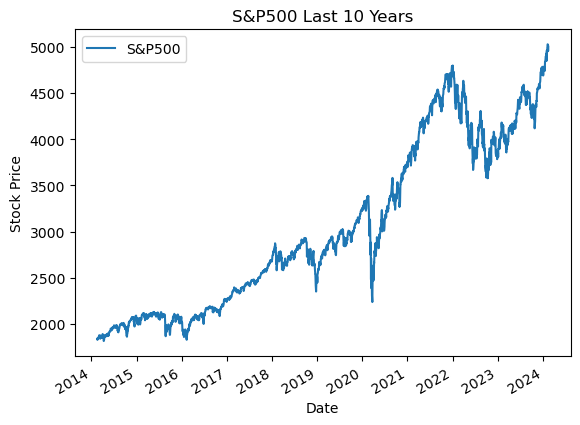

In [5]:
sp_index['Date'] = pd.to_datetime(sp_index.Date,format="%Y-%m-%d")
sp_index.index=sp_index['Date']

# Plot the data
sp_index.plot(x='Date', y='S&P500', kind='line', linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('S&P500 Last 10 Years')

# Show the plot
plt.show()

In [100]:
apple_df = sp_stocks[sp_stocks['Symbol'] == 'AAPL']
apple_df

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
40482,2020-01-02,AAPL,73.059410,75.087502,75.150002,73.797501,74.059998,135480400.0
40483,2020-01-03,AAPL,72.349152,74.357498,75.144997,74.125000,74.287498,146322800.0
40484,2020-01-06,AAPL,72.925644,74.949997,74.989998,73.187500,73.447502,118387200.0
40485,2020-01-07,AAPL,72.582657,74.597504,75.224998,74.370003,74.959999,108872000.0
40486,2020-01-08,AAPL,73.750252,75.797501,76.110001,74.290001,74.290001,132079200.0
...,...,...,...,...,...,...,...,...
41515,2024-02-09,AAPL,188.850006,188.850006,189.990005,188.000000,188.649994,45155200.0
41516,2024-02-12,AAPL,187.149994,187.149994,188.669998,186.789993,188.419998,41781900.0
41517,2024-02-13,AAPL,185.039993,185.039993,186.210007,183.509995,185.770004,56529500.0
41518,2024-02-14,AAPL,184.149994,184.149994,185.529999,182.440002,185.320007,54630500.0


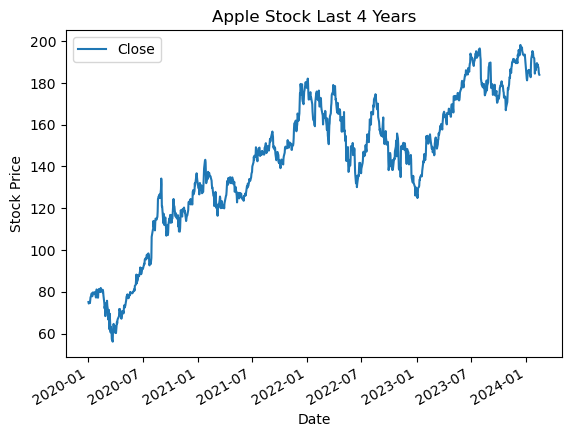

In [101]:
apple_df.plot(x='Date', y='Close', kind='line', linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Apple Stock Last 4 Years')

# Show the plot
plt.show()

In [182]:
apple_df.columns

Index(['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open',
       'Volume'],
      dtype='object')

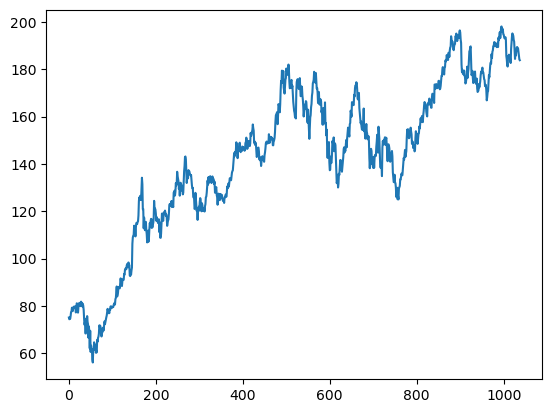

In [183]:
df2 = apple_df.reset_index()['Close']
plt.plot(df2)

In [184]:
scaler = MinMaxScaler()
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))
df2.shape

(1038, 1)

In [185]:
final_dataset

array([ 75.08750153,  74.35749817,  74.94999695, ..., 185.03999329,
       184.1499939 , 183.86000061])

In [186]:
train_data=final_dataset[0:1037]
valid_data=final_dataset[1037:,]

train_size = int(len(df2)*0.80)
test_size = len(df2) - train_size
train_data,test_data = df2[0:train_size,:],df2[train_size:len(df2),:1]

In [187]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [188]:
time_step = 100
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [189]:
# checking values
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(Y_test.shape)

(729, 100)
[[0.13375114 0.1286109  0.13278292 ... 0.16279686 0.16638798 0.16258562]
 [0.1286109  0.13278292 0.13030088 ... 0.16638798 0.16258562 0.16501486]
 [0.13278292 0.13030088 0.13875052 ... 0.16258562 0.16501486 0.16526133]
 ...
 [0.66630874 0.67032227 0.64722654 ... 0.73728592 0.73235697 0.77080288]
 [0.67032227 0.64722654 0.66250633 ... 0.73235697 0.77080288 0.76833845]
 [0.64722654 0.66250633 0.66877327 ... 0.77080288 0.76833845 0.76847921]]
(107, 100)
(107,)


In [190]:
stock_model = Sequential()
stock_model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
stock_model.add(LSTM(50,return_sequences = True))
stock_model.add(LSTM(50))
stock_model.add(Dense(1))
stock_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [191]:
stock_model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 100,batch_size = 32,verbose = 1)

Epoch 1/100
23/23 [==============================] - 7s 127ms/step - loss: 0.0646 - val_loss: 0.0121
Epoch 2/100
23/23 [==============================] - 2s 85ms/step - loss: 0.0065 - val_loss: 0.0152
Epoch 3/100
23/23 [==============================] - 2s 75ms/step - loss: 0.0043 - val_loss: 0.0178
Epoch 4/100
23/23 [==============================] - 2s 83ms/step - loss: 0.0036 - val_loss: 0.0099
Epoch 5/100
23/23 [==============================] - 2s 83ms/step - loss: 0.0031 - val_loss: 0.0055
Epoch 6/100
23/23 [==============================] - 2s 80ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 7/100
23/23 [==============================] - 2s 75ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 8/100
23/23 [==============================] - 2s 73ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 9/100
23/23 [==============================] - 2s 79ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 10/100
23/23 [==============================] - 2s 73ms/step - loss: 0.0030 - val_loss: 0.002

In [192]:
train_predict = stock_model.predict(X_train)
test_predict = stock_model.predict(X_test)

4/4 [==============================] - 0s 23ms/step


In [193]:
# transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [194]:
look_back = 100

trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

testPredictPlot = np.empty_like(df2)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(df2) - 1,:] = test_predict

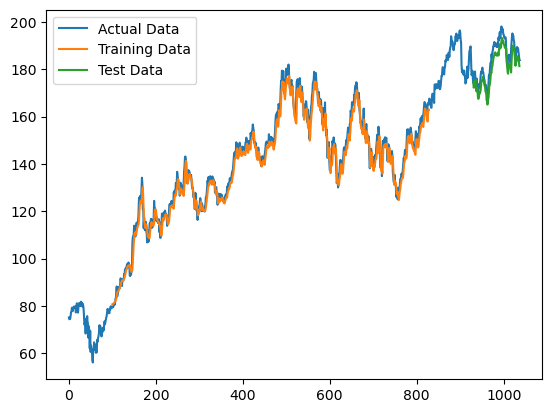

In [195]:
plt.plot(scaler.inverse_transform(df2), label="Actual Data")
plt.plot(trainPredictPlot, label="Training Data")
plt.plot(testPredictPlot, label="Test Data")

plt.legend()
plt.show()

In [196]:
X_test.shape

(107, 100)

In [212]:
# Number of future days to predict
future_days = 1

last_sequence = X_test[-1]

last_sequence = last_sequence.reshape(1, -1)

future_predictions = []

for i in range(future_days):
    # Predict the next day's value
    next_prediction = stock_model.predict(last_sequence)
    
     # Inverse transform to get the actual predicted value
    next_prediction = scaler.inverse_transform(next_prediction)
    
     # Append the prediction to the list of future predictions
    future_predictions.append(next_prediction)

# Print the future predictions
# print(future_predictions)

1/1 [==============================] - 0s 82ms/step


In [213]:
next_prediction

array([[181.35811]], dtype=float32)

In [199]:
df2 = scaler.inverse_transform(df2)
df2

array([[ 75.08750153],
       [ 74.35749817],
       [ 74.94999695],
       ...,
       [185.03999329],
       [184.1499939 ],
       [183.86000061]])

In [210]:
df2 = pd.DataFrame(df2)
df2 = df2[['Close']]
df2

,Close
0,75.087502
1,74.357498
2,74.949997
3,74.597504
4,75.797501
...,...
1033,188.850006
1034,187.149994
1035,185.039993
1036,184.149994


In [211]:
model_data=df2[:1037]
predict_data=df2[1037:]
predict_data['Predictions']=next_prediction
predict_data

/var/folders/by/st2c4w_96757fgwg7jsfc4480000gn/T/ipykernel_77330/451293384.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Predictions']=next_prediction


,Close,Predictions
1037,183.860001,181.358109
